Homework 11
Fit an autoencoder to the chest xray medical mnist dataset. Do the following

Evaluate and compare the training and testing erorr of the autoencoder.
Show the result of feeding a few training and testing images through the autoencoder.
You should submit a single ipynb with your results.

You can install the medical mnist data with the command below. Followin is a set of commands to download the data and load it into a pytorch dataset.

In [1]:
from tqdm import tqdm
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import torch.utils.data as data

import medmnist
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO

In [2]:
data_flag = 'chestmnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])


transform =   transforms.ToTensor()
n_epochs = 10
lr = 0.001
data.transform =transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean=[.5], std=[.5] )
])

train_dataset = DataClass(split='train', transform=transform, download = True)
test_dataset = DataClass(split='test',transform=transform, download = True)
nonorm_dataset=  DataClass(split='train', transform=transforms.ToTensor(), download=True)

Using downloaded and verified file: /home/jupyter-tliu76/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jupyter-tliu76/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jupyter-tliu76/.medmnist/chestmnist.npz


In [3]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(nonorm_dataset)

Dataset ChestMNIST (chestmnist)
    Number of datapoints: 78468
    Root location: /home/jupyter-tliu76/.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST (chestmnist)
    Number of datapoints: 22433
    Root locati

In [4]:
## Load it into a train and test loader

train_loader = data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

/opt/tljh/user/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


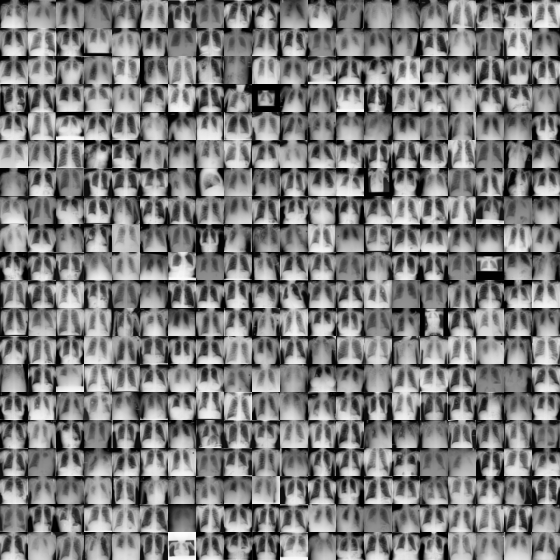

In [5]:
## Visualize the data
train_dataset.montage(length=20)

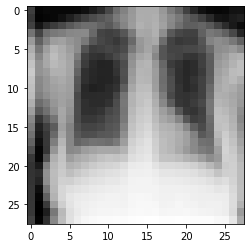

In [6]:
# visualization

img, target = nonorm_dataset[0]
if n_channels == 1:
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
else:
    img = img.permute(1, 2, 0)
    plt.imshow(img)

In [7]:

kernel_size = 5
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 2, kernel_size)
        self.conv2 = nn.Conv2d(2, 4, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.iconv1 = nn.ConvTranspose2d(4, 2, kernel_size+1, stride = 2)
        self.iconv2 = nn.ConvTranspose2d(2, 1, kernel_size+1, stride = 2)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.iconv1(x))
        ## Use the sigmoid as the final layer 
        ## since we've normalized pixel values to be between 0 and 1
        x = torch.sigmoid(self.iconv2(x))
        return(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))
autoencoder = autoencoder()
    

In [8]:
## Here's some example data by grabbing one batch
tryItOut,label = iter(train_loader).next()
print(tryItOut.shape)

## Let's encode that data
encoded = autoencoder.encode(tryItOut)
print(encoded.shape)

## Now let's decode the encoded data
decoded = autoencoder.decode(encoded)
print(decoded.shape)

## Now let's run the whole thing through
fedForward = autoencoder.forward(tryItOut)
print(fedForward.shape)


torch.Size([100, 1, 28, 28])
torch.Size([100, 4, 4, 4])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


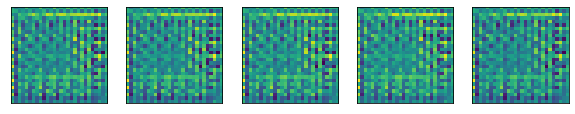

In [9]:
test = fedForward.detach().numpy()

## Plot out the first 5 images, note this isn't very interesting, since
## all of the weights haven't been trained
plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(test[i,:,:,:], (1, 2, 0))
  plt.imshow(img)

In [10]:
#Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

#Epochs
n_epochs = 20

autoencoder.train()


autoencoder(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (iconv1): ConvTranspose2d(4, 2, kernel_size=(6, 6), stride=(2, 2))
  (iconv2): ConvTranspose2d(2, 1, kernel_size=(6, 6), stride=(2, 2))
)

In [11]:
#Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

#Epochs
n_epochs = 20

autoencoder.train()

for epoch in range(n_epochs):
    for data in train_loader:
        images, label = data
        optimizer.zero_grad()
        outputs = autoencoder.forward(images)
        loss = F.mse_loss(outputs,images)
        loss.backward()
        optimizer.step()
        

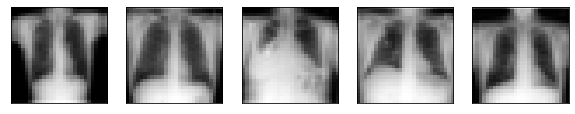

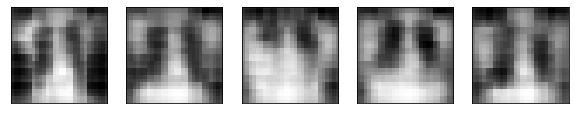

In [12]:
## the data from the last iteration is called images
trainSample = images.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img1 = np.transpose(trainSample[i,:,:,:], (1, 2, 0))
  plt.imshow(img1,cmap='gray')

## the output from the last iterations (feed forward through the network) is called outputs
trainOutput = outputs.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(2, 5,i+6)
  plt.xticks([])
  plt.yticks([])
  img2 = np.transpose(trainOutput[i,:,:,:], (1, 2, 0))
  plt.imshow(img2,cmap='gray')

In [19]:
from sklearn.metrics import mean_squared_error

In [35]:
print('Training Error= ',np.sqrt(np.square(np.subtract(trainSample,trainOutput)).mean()))

Training Error=  0.09467531


In [32]:
for data in test_loader:
  images,label = data
  outputs = autoencoder.forward(images)

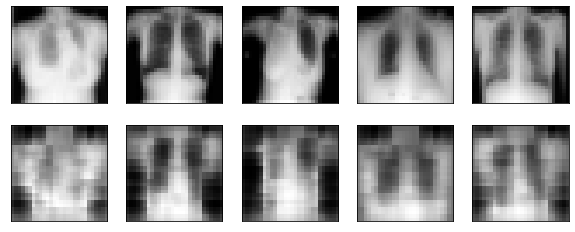

In [33]:
##TestSample:

testSample = images.detach().numpy()

plt.figure(figsize=(10,4))

## Plot the original data
for i in range(5): 
  plt.subplot(2, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(testSample[i,:,:,:], (1, 2, 0))
  plt.imshow(img,cmap='gray')


# Plot the data having been run throught the convolutional autoencoder

testOutput = outputs.detach().numpy()


for i in range(5): 
  plt.subplot(2, 5, i + 6)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(testOutput[i,:,:,:], (1, 2, 0))
  plt.imshow(img,cmap='gray')


In [36]:
print('Testing Error= ',np.sqrt(np.square(np.subtract(testSample,testOutput)).mean()))

Testing Error=  0.0927309
